In [1]:
#导一个包      pip install bayesian-optimization==0.6 

I use `bayesian-optimization==0.6`, my backend pretty much stick with this version, so migrating will break the code.

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
from bayes_opt import BayesianOptimization
sns.set()

In [3]:
import pkg_resources
import types


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))

seaborn==0.9.0
pandas==0.24.2
numpy==1.16.3
matplotlib==3.1.0


In [4]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

TSLA Time Period: **Mar 23, 2018 - Mar 23, 2019**

In [5]:
df = pd.read_csv('maotai2015.csv')
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-09-24,196.279999,192.800003,195.800003,194.000000,1388674.0,181.763428
1,2015-09-25,194.899994,189.500000,193.990005,193.460007,2445597.0,181.257492
2,2015-09-28,192.300003,189.229996,191.479996,191.380005,1234110.0,179.308670
3,2015-09-29,191.369995,188.300003,189.550003,190.169998,1840982.0,178.175003
4,2015-09-30,191.479996,190.169998,190.229996,190.309998,1163463.0,178.306168


In [6]:
close = df.Close.values.tolist()   #转换成列表
window_size = 30
skip = 5
l = len(close) - 1

In [7]:
class Deep_Evolution_Strategy:    #深度优化

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]  #点积
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [17]:
class Agent:    #中间变量代换
    def __init__(
        self,
        population_size,
        sigma,
        learning_rate,
        model,
        money,
        max_buy,
        max_sell,
        skip,
        window_size,
    ):
        self.window_size = window_size
        self.skip = skip
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(close, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = get_state(close, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10),dpi=800)
        df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
        df.index = df['Date']
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.show()

In [9]:
def best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    model = Model(window_size, size_network, 3)
    agent = Agent(
        population_size,
        sigma,
        learning_rate,
        model,
        10000,
        5,
        5,
        skip,
        window_size,
    )
    try:
        agent.fit(100, 1000)
        return agent.es.reward_function(agent.es.weights)
    except:
        return 0

In [10]:
def find_best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    global accbest
    param = {
        'window_size': int(np.around(window_size)),
        'skip': int(np.around(skip)),
        'population_size': int(np.around(population_size)),
        'sigma': max(min(sigma, 1), 0.0001),
        'learning_rate': max(min(learning_rate, 0.5), 0.000001),
        'size_network': int(np.around(size_network)),
    }
    print('\nSearch parameters %s' % (param))
    investment = best_agent(**param)
    print('stop after 100 iteration with investment %f' % (investment))
    if investment > accbest:
        costbest = investment
    return investment

In [11]:
accbest = 0.0
NN_BAYESIAN = BayesianOptimization(
    find_best_agent,
    {
        'window_size': (2, 50),
        'skip': (1, 15),
        'population_size': (1, 50),
        'sigma': (0.01, 0.99),
        'learning_rate': (0.000001, 0.49),
        'size_network': (10, 1000),
    },
)
NN_BAYESIAN.maximize(init_points = 30, n_iter = 50, acq = 'ei', xi = 0.0)

Initialization
----------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   learning_rate |   population_size |     sigma |   size_network |      skip |   window_size | 

Search parameters {'window_size': 4, 'skip': 8, 'population_size': 42, 'sigma': 0.06357376770292678, 'learning_rate': 0.16080696711616854, 'size_network': 160}


E:\Anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
    1 | 00m05s |    0.00000 |          0.1608 |           42.3008 |    0.0636 |       159.7530 |    7.9786 |        3.9995 | 

Search parameters {'window_size': 8, 'skip': 9, 'population_size': 9, 'sigma': 0.7825768003786238, 'learning_rate': 0.4469044618207578, 'size_network': 316}
time taken to train: 4.132142066955566 seconds
stop after 100 iteration with investment 258.145197
    2 | 00m04s |  258.14520 |          0.4469 |            8.6521 |    0.7826 |       315.9997 |    8.5544 |        7.5971 | 

Search parameters {'window_size': 17, 'skip': 8, 'population_size': 20, 'sigma': 0.8466849570344441, 'learning_rate': 0.3959147180059602, 'size_network': 737}
time taken to train: 17.58379888534546 seconds
stop after 100 iteration with investment 318.321311
    3 | 00m17s |  318.32131 |          0.3959 |           19.7031 |    0.8467 |       736.5049 |    7.9062 |       17.1800 | 

Search parameters {'window_size': 16, 'skip': 14, 'popu

time taken to train: 26.773654460906982 seconds
stop after 100 iteration with investment 337.734000
   22 | 00m26s |  337.73400 |          0.2165 |           30.6324 |    0.4148 |       988.8684 |   10.8212 |       33.7689 | 

Search parameters {'window_size': 45, 'skip': 6, 'population_size': 21, 'sigma': 0.2805223400095086, 'learning_rate': 0.008856267301036181, 'size_network': 531}
time taken to train: 33.26858830451965 seconds
stop after 100 iteration with investment 78.430203
   23 | 00m33s |   78.43020 |          0.0089 |           20.5907 |    0.2805 |       530.9367 |    6.0336 |       44.9358 | 

Search parameters {'window_size': 46, 'skip': 6, 'population_size': 48, 'sigma': 0.8124790662388893, 'learning_rate': 0.21145944780812853, 'size_network': 734}
time taken to train: 82.36658644676208 seconds
stop after 100 iteration with investment 358.703594
   24 | 01m22s |  358.70359 |          0.2115 |           47.5280 |    0.8125 |       733.8382 |    6.1955 |       45.7237 | 

S

time taken to train: 15.009319305419922 seconds
stop after 100 iteration with investment 291.266002
   42 | 00m16s |  291.26600 |          0.1705 |           31.1697 |    0.4757 |       995.1407 |   12.8318 |       36.5402 | 

Search parameters {'window_size': 29, 'skip': 9, 'population_size': 39, 'sigma': 0.21776778668421667, 'learning_rate': 0.4824020714065319, 'size_network': 450}
time taken to train: 17.43295931816101 seconds
stop after 100 iteration with investment 317.225192
   43 | 00m18s |  317.22519 |          0.4824 |           38.7270 |    0.2178 |       450.2542 |    9.4169 |       28.5450 | 

Search parameters {'window_size': 42, 'skip': 11, 'population_size': 9, 'sigma': 0.5296210754510797, 'learning_rate': 0.4265650062256906, 'size_network': 456}
time taken to train: 4.061272382736206 seconds
stop after 100 iteration with investment 303.736305
   44 | 00m05s |  303.73630 |          0.4266 |            9.3176 |    0.5296 |       456.3971 |   10.6969 |       41.8878 | 

Se

E:\Anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide



Search parameters {'window_size': 6, 'skip': 13, 'population_size': 16, 'sigma': 0.3435097569908273, 'learning_rate': 0.17677821595348844, 'size_network': 579}
time taken to train: 3.284297466278076 seconds
stop after 100 iteration with investment 186.001091
   48 | 00m04s |  186.00109 |          0.1768 |           16.3401 |    0.3435 |       578.7945 |   12.9888 |        6.0838 | 

Search parameters {'window_size': 39, 'skip': 2, 'population_size': 15, 'sigma': 0.5287594088641112, 'learning_rate': 0.19075178072435864, 'size_network': 371}
time taken to train: 23.83405351638794 seconds
stop after 100 iteration with investment 372.114391
   49 | 00m25s |  372.11439 |          0.1908 |           15.1521 |    0.5288 |       371.4969 |    2.1780 |       38.5535 | 

Search parameters {'window_size': 28, 'skip': 13, 'population_size': 48, 'sigma': 0.8856016639892579, 'learning_rate': 0.032088415826448655, 'size_network': 293}
time taken to train: 11.6621994972229 seconds
stop after 100 iter

E:\Anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
   58 | 00m02s |    0.00000 |          0.2619 |           13.4604 |    0.0258 |       686.2973 |   13.0098 |       48.5496 | 

Search parameters {'window_size': 15, 'skip': 15, 'population_size': 28, 'sigma': 0.571183274117416, 'learning_rate': 0.18511044577460084, 'size_network': 584}
time taken to train: 6.174692392349243 seconds
stop after 100 iteration with investment 227.331199
   59 | 00m07s |  227.33120 |          0.1851 |           28.1778 |    0.5712 |       584.3248 |   14.8560 |       15.1088 | 

Search parameters {'window_size': 44, 'skip': 2, 'population_size': 26, 'sigma': 0.1476593158912487, 'learning_rate': 0.11721676635064861, 'size_network': 465}
time taken to train: 46.219918966293335 seconds
stop after 100 iteration with investment 387.758992
   60 | 00m47s |  387.75899 |          0.1172 |           26.3029 |    0.1477 |       464.6320 |    2.2429 |       43.5045 | 

Search parameters {'window_size': 15, 'skip': 2, '


Search parameters {'window_size': 6, 'skip': 5, 'population_size': 13, 'sigma': 0.5817129993549444, 'learning_rate': 0.018192886427492724, 'size_network': 324}
time taken to train: 5.714905023574829 seconds
stop after 100 iteration with investment 31.197095
   80 | 00m07s |   31.19710 |          0.0182 |           12.7977 |    0.5817 |       323.8850 |    4.8543 |        6.3793 | 


In [12]:
print('Best AGENT accuracy value: %f' % NN_BAYESIAN.res['max']['max_val'])
print('Best AGENT parameters: ', NN_BAYESIAN.res['max']['max_params'])

Best AGENT accuracy value: 472.415096
Best AGENT parameters:  {'window_size': 42.98654481615584, 'skip': 1.6231110859446323, 'population_size': 28.040756280003183, 'sigma': 0.2954936359540277, 'learning_rate': 0.11058307934808022, 'size_network': 463.30563429237293}


#### My selected parameters

In [13]:
best_agent(
    window_size = 30, 
    skip = 1, 
    population_size = 15, 
    sigma = 0.1, 
    learning_rate = 0.03, 
    size_network = 500
)

time taken to train: 47.103596210479736 seconds


448.4614193725586

#### bayesian parameters

In [14]:
best_agent(
    window_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['window_size'])), 
    skip = int(np.around(NN_BAYESIAN.res['max']['max_params']['skip'])), 
    population_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['population_size'])), 
    sigma = NN_BAYESIAN.res['max']['max_params']['sigma'], 
    learning_rate = NN_BAYESIAN.res['max']['max_params']['learning_rate'], 
    size_network = int(np.around(NN_BAYESIAN.res['max']['max_params']['size_network']))
)

time taken to train: 50.87563705444336 seconds


385.07509811401366

#### My selected parameters

iter 100. reward: 418.432901
iter 200. reward: 482.938411
iter 300. reward: 485.855714
iter 400. reward: 539.100012
iter 500. reward: 549.506512
time taken to train: 248.60963487625122 seconds
day 0: buy 5 units at price 970.000000, total balance 9030.000000
day 1: buy 5 units at price 967.300034, total balance 8062.699966
day 2: buy 5 units at price 956.900024, total balance 7105.799942
day 3: buy 5 units at price 950.849991, total balance 6154.949951
day 4: buy 5 units at price 951.549988, total balance 5203.399963
day 5: buy 1 units at price 197.520004, total balance 5005.879959
day 7, sell 5 units at price 990.449982, investment 2.108246 %, total balance 5996.329941,
day 8: buy 1 units at price 198.740005, total balance 5797.589935
day 9: buy 5 units at price 989.150009, total balance 4808.439926
day 10: buy 5 units at price 999.950027, total balance 3808.489899
day 13: buy 1 units at price 201.970001, total balance 3606.519897
day 14: buy 5 units at price 1001.549988, total balanc

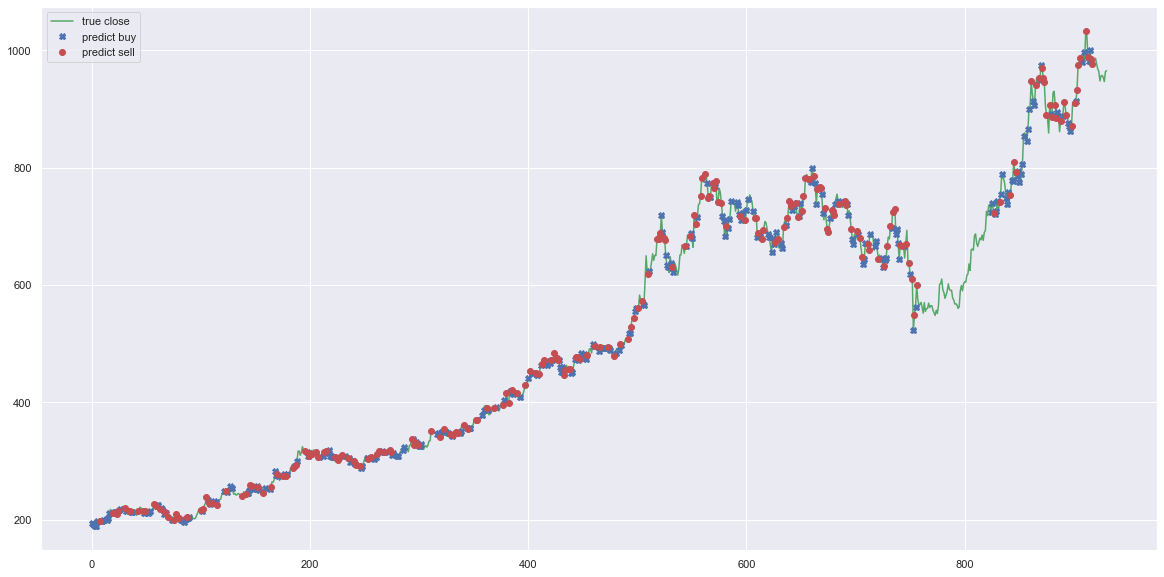

In [18]:
model = Model(input_size = 30, 
              layer_size = 500, 
              output_size = 3)
agent = Agent(population_size = 15, 
              sigma = 0.1, 
              learning_rate = 0.03, 
              model = model, 
              money = 10000, 
              max_buy = 5, 
              max_sell = 5, 
              skip = 1, 
              window_size = 30)
agent.fit(500, 100)
agent.buy()

#### bayesian parameters

iter 100. reward: 418.160000
iter 200. reward: 413.680791
iter 300. reward: 493.049295
iter 400. reward: 528.815904
iter 500. reward: 561.418302
time taken to train: 595.3113372325897 seconds
day 0: buy 5 units at price 970.000000, total balance 9030.000000
day 2: buy 5 units at price 956.900024, total balance 8073.099976
day 4: buy 5 units at price 951.549988, total balance 7121.549988
day 8: buy 1 units at price 198.740005, total balance 6922.809982
day 12: buy 5 units at price 1013.600006, total balance 5909.209976
day 14: buy 5 units at price 1001.549988, total balance 4907.659988
day 16: buy 1 units at price 210.979996, total balance 4696.679993
day 18: buy 1 units at price 215.250000, total balance 4481.429993
day 20: buy 5 units at price 1065.000000, total balance 3416.429993
day 22: buy 5 units at price 1062.799988, total balance 2353.630005
day 24: buy 5 units at price 1074.899979, total balance 1278.730026
day 28, sell 5 units at price 1111.900024, investment 14.628868 %, tot

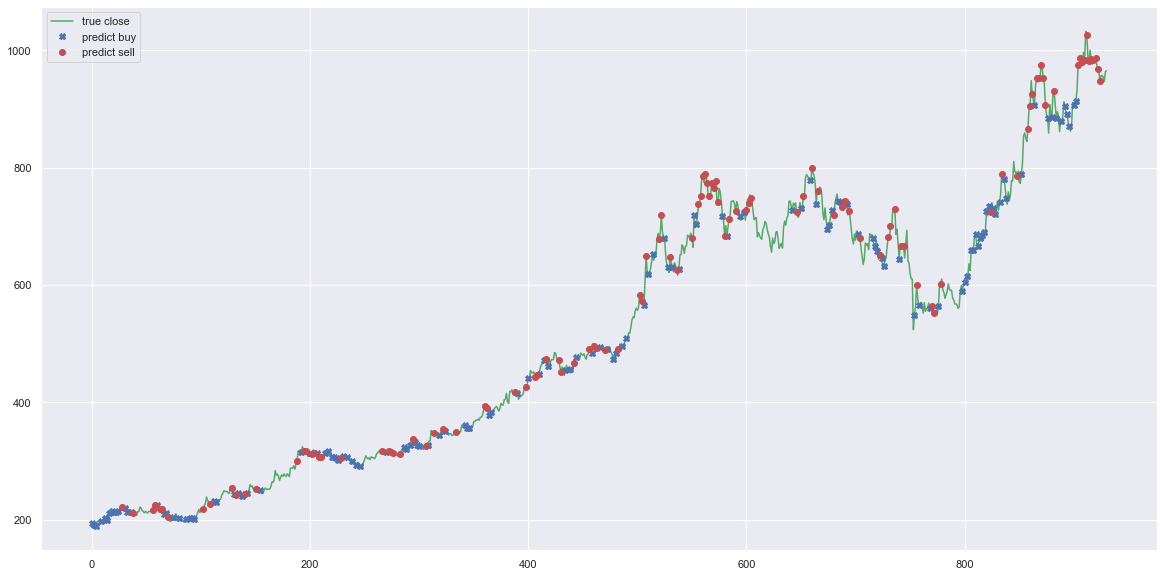

In [16]:
model = Model(input_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['window_size'])), 
              layer_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['size_network'])), 
              output_size = 3)
agent = Agent(population_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['population_size'])), 
              sigma = NN_BAYESIAN.res['max']['max_params']['sigma'], 
              learning_rate = NN_BAYESIAN.res['max']['max_params']['learning_rate'], 
              model = model, 
              money = 10000, 
              max_buy = 5, 
              max_sell = 5, 
              skip = int(np.around(NN_BAYESIAN.res['max']['max_params']['skip'])), 
              window_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['window_size'])))
agent.fit(500, 100)
agent.buy()